# DSA5201X Project: Stroke Prediction
Name: Cai Bowen  
Student Number: A0236104U

## Project Description

### 1. Data Set
The data set is downloaded [here](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)\.  
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.  
The data set provides information about the patients like gender, age, various diseases, smoking status, and whether the patient get stroke.

### 2. Goal
- Use the information of patients to predict whether a patient is likely to get stroke.
- Find which parameter contributes to stroke, so that we can adjust our lifestyle to avoid getting stroke.

## Content
1. [Importing Packages and Data](#1.-Importing-Packages-and-Data)

## 1. Importing Packages and Data

Import the packages used in the analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

In [2]:
# sampling
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
# preprocessing
from sklearn.preprocessing import MinMaxScaler
# cross validation
from sklearn.model_selection import GridSearchCV
# unsupervised learning
from sklearn.decomposition import PCA, KernelPCA
# supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
# neural network
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# model evaluation
from sklearn.metrics import classification_report, plot_roc_curve, matthews_corrcoef

Import the data

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Check the data size

In [4]:
df.shape

(5110, 12)

Check if there are empty values

In [5]:
df.isnull().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

## 2. Exploratory Data Analysis
In this part, I will visualize the correlation between each paramater with the target column, in order to find some patterns.

### 2.1 Stroke (the Output)
First, let's check distribution of the output column "stroke".  
From the plot, we can see that the stroke distribution is imbalanced, only about 5% of the data is stroke.
We need to deal with the imbalanced data before training.

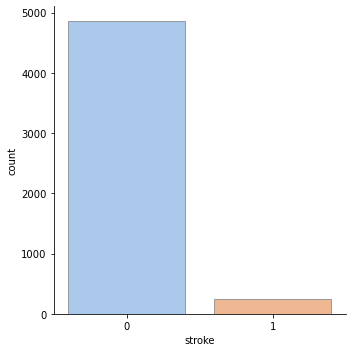

In [6]:
sns.catplot(x='stroke', kind='count', palette='pastel', edgecolor='.6', data=df)

In [7]:
stroke_counts = df['stroke'].value_counts()
print(f'The proportion of stroke: {stroke_counts[1]/stroke_counts.sum(): .2%}')

The proportion of stroke:  4.87%


### 2.2 Gender

There is 1 record with "Other" gender. Consider to drop it.

In [8]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [9]:
df = df[df['gender'] != 'Other'].copy()

Now check the correlation between gender and stroke. Use confusion matrix to get the proportion of stroke in each gender.  
There is no significant difference between male and female in getting stroke.

In [10]:
pd.crosstab(df.loc[df['gender'] != 'Other', 'gender'], 
            df.loc[df['gender'] != 'Other', 'stroke'], normalize='index').round(2)

stroke,0,1
gender,,
Female,0.95,0.05
Male,0.95,0.05


### 2.3 Age

The distribution of age is nearly even. Age of 40-60 has slightly more records.

<AxesSubplot:xlabel='age', ylabel='Count'>

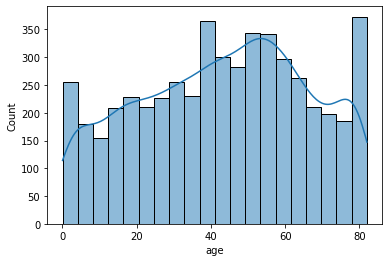

In [11]:
sns.histplot(x='age', data=df, bins=20, kde=True)

From the plot, we can tell that starting from age of 40, older people have higher probability of getting stroke.

<AxesSubplot:xlabel='age', ylabel='Proportion of Stroke'>

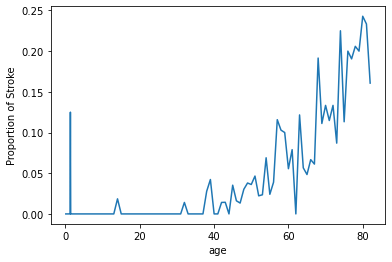

In [12]:
df.groupby('age').mean()['stroke'].plot(ylabel='Proportion of Stroke')

### 2.4 Hypertension

About 10% of records have hypertension

In [13]:
hyp_ten_counts = df['hypertension'].value_counts()
print(f'The proportion of hypertension: {hyp_ten_counts[1]/hyp_ten_counts.sum():.2%}')

The proportion of hypertension: 9.75%


From the confusion matrix, we can tell that people with hypertension are more likely to get a stroke.

In [14]:
pd.crosstab(df['hypertension'], df['stroke'], normalize='index').round(2)

stroke,0,1
hypertension,,
0,0.96,0.04
1,0.87,0.13


### 2.5 Heart Disease

About 5% of records have heart disease.

In [15]:
hrt_dis_counts = df['heart_disease'].value_counts()
print(f'The proportion of heart disease: {hrt_dis_counts[1]/hrt_dis_counts.sum():.2%}')

The proportion of heart disease: 5.40%


We can also find that people with heart disease are more likely to get a stroke.

In [16]:
pd.crosstab(df['heart_disease'], df['stroke'], normalize='index').round(2)

stroke,0,1
heart_disease,,
0,0.96,0.04
1,0.83,0.17


### 2.6 Ever Married

"Ever Married" column are correlated with age, because older people are more likely to be married.

In [17]:
df['ever_married'].value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

<AxesSubplot:xlabel='age', ylabel='count'>

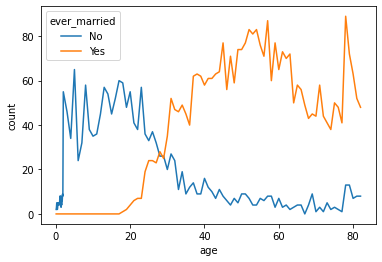

In [18]:
df.groupby(['age', 'ever_married']).size().unstack(fill_value=0).plot(ylabel='count')

Because older people are more likely to get stroke, so we can also find that married people also have a higher proportion of getting stroke.

In [19]:
pd.crosstab(df['ever_married'], df['stroke'], normalize='index').round(2)

stroke,0,1
ever_married,,
No,0.98,0.02
Yes,0.93,0.07


### 2.7 Work Type

In [20]:
df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

From the cross table, we can find that children and people never worked have lower stroke rate.

In [21]:
pd.crosstab(df['work_type'], df['stroke'], normalize='index').round(2)

stroke,0,1
work_type,,
Govt_job,0.95,0.05
Never_worked,1.00,0.00
Private,0.95,0.05
Self-employed,0.92,0.08
children,1.00,0.00


This is also because of the age. Children and people never worked are all young people with maximum age of 23.

In [22]:
print(f'Max age of "children": {max(df.loc[df["work_type"] == "children", "age"])}')
print(f'Max age of "Never_worked": {max(df.loc[df["work_type"] == "Never_worked", "age"])}')

Max age of "children": 16.0
Max age of "Never_worked": 23.0


### 2.8 Residence Type

There is no significant difference between urban and rural residence to get stroke.

In [23]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

In [24]:
pd.crosstab(df['Residence_type'], df['stroke'], normalize='index').round(2)

stroke,0,1
Residence_type,,
Rural,0.95,0.05
Urban,0.95,0.05


### 2.9 Average Glucose Level

From the histogram of glucose level, we can find that the majority people have an average glucose level lower than 150. But some people have very high glucose level to about 250.

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

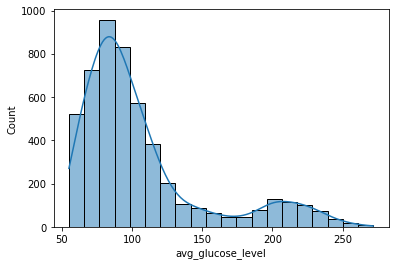

In [25]:
sns.histplot(x='avg_glucose_level', data=df, bins=20, kde=True)

People with higher average glucose level are more likely to get stroke.

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Proportion of Stroke'>

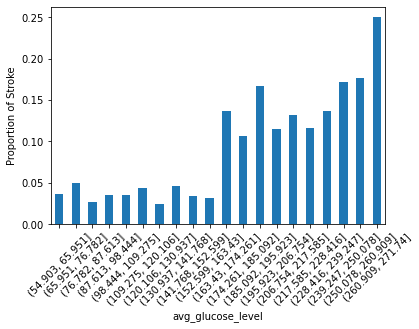

In [26]:
df.groupby(pd.cut(df['avg_glucose_level'], bins=20)).mean()['stroke']\
    .plot.bar(rot=45, ylabel='Proportion of Stroke')

### 2.10 BMI

There is 201 instances have empty value in BMI column. We need to fill these numbers later in data preprocessing part.

In [27]:
print(f'Number of empty values in BMI: {df[df["bmi"].isnull()].shape[0]}')
print(f'The proportion of empty value is {df[df["bmi"].isnull()].shape[0] / df.shape[0]:.2%}')

Number of empty values in BMI: 201
The proportion of empty value is 3.93%


The majority of BMI ranges between 10-60.

<AxesSubplot:xlabel='bmi', ylabel='Count'>

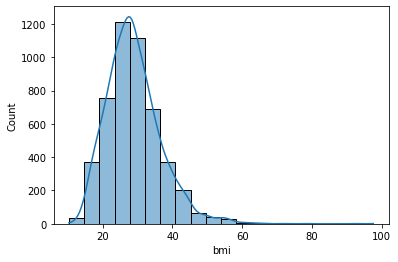

In [28]:
sns.histplot(x='bmi', data=df, bins=20, kde=True)

The proportion of getting stroke varies between BMI, but no clearly positive or negative correlation was found.

<AxesSubplot:xlabel='bmi', ylabel='Proportion of Stroke'>

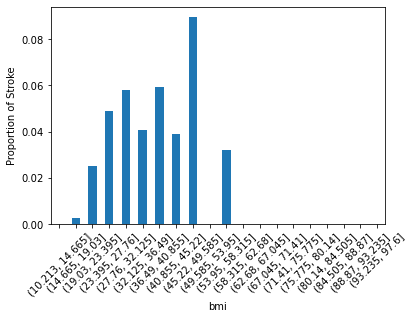

In [29]:
df.groupby(pd.cut(df['bmi'], bins=20)).mean()['stroke']\
    .plot.bar(rot=45, ylabel='Proportion of Stroke')

### 2.11 Smoking Status

30% of the smoking status is unknown.

In [30]:
smoking_counts = df['smoking_status'].value_counts()
smoking_counts

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [31]:
print(f'The proportion of unknown smoking status: '
      '{smoking_counts["Unknown"]/smoking_counts.sum():.2%}')

The proportion of unknown smoking status: {smoking_counts["Unknown"]/smoking_counts.sum():.2%}


Formerly smoked people have a higher chance of getting stroke.

In [32]:
pd.crosstab(df['smoking_status'], df['stroke'], normalize='index').round(2)

stroke,0,1
smoking_status,,
Unknown,0.97,0.03
formerly smoked,0.92,0.08
never smoked,0.95,0.05
smokes,0.95,0.05


## 3. Data Preprocessing

### 3.1 Convert the categorical variables to numerical

For the binary variables, such as gender, married and residence type, we just need to encode it as 0/1.

In [33]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1}).astype(np.uint8)
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].map({'Rural': 0, 'Urban': 1}).astype(np.uint8)

For the other categorical variables, work type and smoking status, we need to use one-hot encoding.

In [34]:
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'])

Smoking status contains unknown values, so we can drop the one-hot column representing the unknown value.  
As a result, those records with unknown smoking status will be encoded as all 0 in smoking status one-hot columns.

In [35]:
df = df.drop('smoking_status_Unknown', axis=1)

Now, the input variables are all numerical.  
We can set the input column names and target column name.  ID is a unique identity of each record, but contains no information, so we do not input this column.

In [36]:
target_col = 'stroke'

feature_cols = list(df.columns)
feature_cols.remove('id')
feature_cols.remove(target_col)

### 3.2 Train Test Split

Select 20% of the data as test set. Use stratified split to make the proportion of target class is the same in training and test set.

In [37]:
X_train, X_test, y_train, y_test \
    = train_test_split(df[feature_cols], df[target_col], test_size = 0.2, stratify=df[target_col])

In [38]:
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Number of features: {X_train.shape[1]}')

Training set size: 4087
Test set size: 1022
Number of features: 16


### 3.3 Process the Empty Values in BMI

Consider to fill the empty BMI with median value.  
To avoid the leakage of information from test set, we should use only compute the median value based on training set.

In [39]:
bmi_median = X_train['bmi'].median(skipna=True)
print(f'Median value of BMI used to fill empty value: {bmi_median}')

Median value of BMI used to fill empty value: 28.1


In [40]:
X_train = X_train.fillna({'bmi': bmi_median})
X_test = X_test.fillna({'bmi': bmi_median})

Now, all the input variables are numerical. We can use a compute the correlation matrix of all the features.  
From the matrix, we can see that age and ever married have a positive correlation.

<AxesSubplot:>

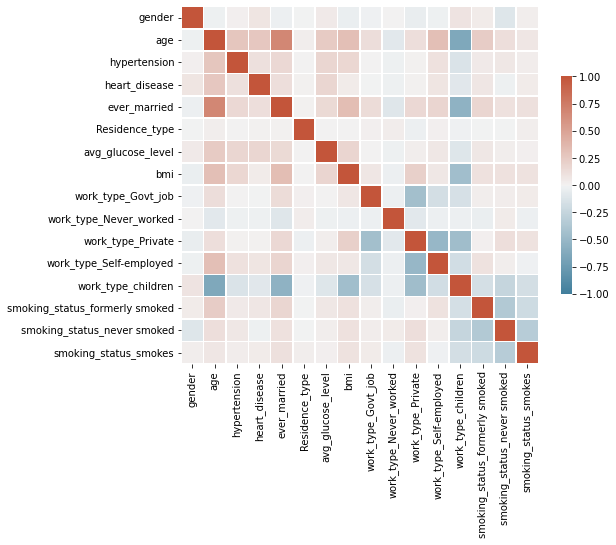

In [41]:
# Compute the correlation matrix with pearson
corr = X_train.corr(method='pearson')

# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 3.4 Normalization

We need to normalize the data for PCA and model training. Here I will use min-max scaler.  
In order to prevent the information leakage from test set, min and max value should only be computed on training set.

In [42]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Unsupervised Learning
In this part, I will use PCA and kernel PCA to perform dimension reduction in input variables. And also find if the dimension reduced data set will perform better in supervised learning task.  
Given that the number of features is not large, using a complex neural network to train an autoencoder is not a good idea here.

### 4.1 PCA

Let's first find the best number of components we will use in PCA.

In [43]:
pca = PCA()
pca.fit(X_train)

PCA()

From the below graph, we can see that the first 9 components explain most of the variance. So we are going to choose 9 components in PCA transformation.

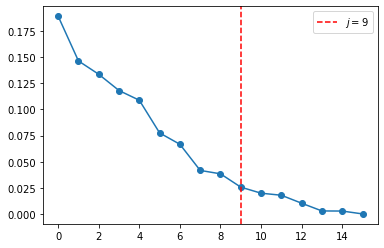

In [44]:
plt.plot(pca.explained_variance_ratio_, '-o')
plt.axvline(x=9, c='r', ls='--', label=r'$j=9$')
plt.legend()

In [45]:
print(f'The first 9 components can explain {sum(pca.explained_variance_ratio_[:9]):.2%} '
      'of the variance')

The first 9 components can explain 92.08% of the variance


Also check the first 2 principle components. We can see that they all shows the correlation between age, ever married and work type, which is what we have found in EDA.

<AxesSubplot:>

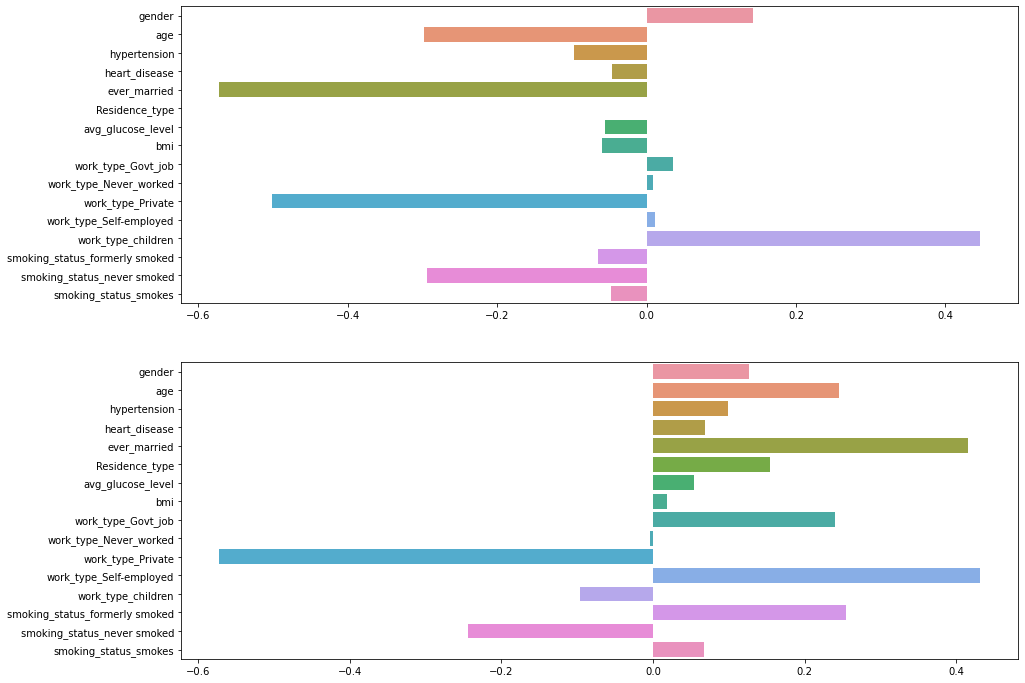

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
sns.barplot(x=pca.components_[0], y=feature_cols, orient='h', ax=ax[0])
sns.barplot(x=pca.components_[1], y=feature_cols, orient='h', ax=ax[1])

Let's use the 9 components to reduce the dimension of input variables.

In [47]:
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### 4.2 Kernel PCA
Also try the performance of non-linear kernel PCA.  

#### Polynomial Kernel
First try the polynomial kernel.

In [48]:
kpca_poly = KernelPCA(kernel='poly', degree=3)
kpca_poly.fit(X_train)

KernelPCA(kernel='poly')

Still using first 9 components.

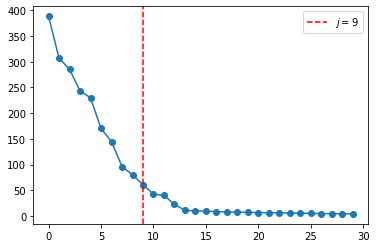

In [49]:
plt.plot(kpca_poly.lambdas_[:30], '-o')
plt.axvline(x=9, c='r', ls='--', label=r'$j=9$')
plt.legend()

In [50]:
print(f'The first 9 components can explain {sum(kpca_poly.lambdas_[:9])/sum(kpca_poly.lambdas_):.2%} '
      'of the variance with polynomial kernel')

The first 9 components can explain 84.83% of the variance with polynomial kernel


#### RBF kernel
Also check the performance of RBF kernel.

In [51]:
kpca_rbf = KernelPCA(kernel='rbf')
kpca_rbf.fit(X_train)

KernelPCA(kernel='rbf')

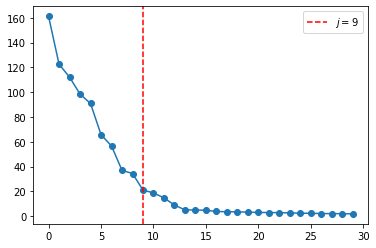

In [52]:
plt.plot(kpca_rbf.lambdas_[:30], '-o')
plt.axvline(x=9, c='r', ls='--', label=r'$j=9$')
plt.legend()

In [53]:
print(f'The first 9 components can explain {sum(kpca_rbf.lambdas_[:9])/sum(kpca_rbf.lambdas_):.2%} '
      'of the variance with RBF kernel')

The first 9 components can explain 83.87% of the variance with RBF kernel


#### PCA transformation with polynomial kernel
Polynomial kernel performs better than RBF kernel, so we will use polynomial kernel PCA to transform the data set.

In [54]:
kpca = KernelPCA(n_components=9, kernel='poly', degree=3)
X_train_kpca = kpca.fit_transform(X_train)
X_test_kpca = kpca.transform(X_test)

## 5. Supervised Learning
In this part, I will use the models list below to predict whether the patient will get a stroke:
- Logistic Regression
- Decision Tree
- Random Forest
- AdaBoost
- Neural Network

Before we start training, we need to first balance our data.
That's because only 5% of the data is stroke, and that will influence our prediction accuracy.  
Here I will use random duplication to over-sample the minority class.

In [55]:
X_train_smote, y_train_smote = RandomOverSampler().fit_resample(X_train, y_train)
X_train_pca_smote, y_train_pca_smote = RandomOverSampler().fit_resample(X_train_pca, y_train)
X_train_kpca_smote, y_train_kpca_smote = RandomOverSampler().fit_resample(X_train_kpca, y_train)

Then define a function to train classification model.  
Use GridSearchCV to tune the hyperparameter with 5-fold validation.

In [56]:
def train_model(clf, X_train, y_train, param_grid, scoring='accuracy', n_jobs=-1):
    # Use GridSearchCV to tune the hyperparameter
    grid = GridSearchCV(clf, param_grid, scoring=scoring, cv=5, n_jobs=n_jobs)
    grid.fit(X_train, y_train)
    
    # Show the result
    print(f'Best parameters: {grid.best_params_}')
    print(f'Best accuracy: {grid.best_score_: .4f}')
    
    # Return the best classifier
    return grid.best_estimator_

Also define a function to show the classification result on test set.  
Here I use Matthews correlation coefficient (MCC) to score the model on test set. It is a suitable choice for imbalanced data classification.

In [57]:
# Record the score of each model
model_scores = pd.DataFrame(columns=['Model Type', 'Data Set', 'MCC Score'])

In [58]:
def test_model(clf, X_test, y_test, model_type, data_set_type, show_report=False):
    global model_scores

    y_pred = clf.predict(X_test)
    
    # Show the classification_report or not
    if show_report:
        print(classification_report(y_test, y_pred))
        
    mcc_score = matthews_corrcoef(y_test, y_pred)
    print(f'MCC score: {mcc_score: .4f}')
    model_scores = model_scores.append({'Model Type': model_type, 'Data Set': data_set_type, 
                                        'MCC Score': mcc_score}, ignore_index=True)

### 5.1 Logistic Regression

Setting the hyperparameters for tuning.

In [59]:
params = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
}

#### a) Using the original features

Use the training set to train the model.

In [60]:
clf_logis = train_model(LogisticRegression(tol=0.0001, max_iter=1000), 
                        X_train_smote, y_train_smote, params)

Best parameters: {'C': 0.05}
Best accuracy:  0.7787


Test the model with test set.  
The test set is imbalanced, so the precision of positive class is low. But both classes have recall more than 70%, which is much better than random guess.

In [61]:
test_model(clf_logis, X_test, y_test, 'Logistic Regression', 'Original', show_report=True)

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.14      0.84      0.24        50

    accuracy                           0.74      1022
   macro avg       0.56      0.79      0.54      1022
weighted avg       0.95      0.74      0.81      1022

MCC score:  0.2692


We can also check the coefficients in the logistic regression model to find some details.
- Age is the dominant features here. Older people have higher chance of getting stroke.
- The second and third positive features are glucose level and hypertension, which means people with higher glucose level and hypertension are more likely to get stroke.
- The first negative feature is BMI, so people with lower BMI are slightly more likely to get stroke.

<AxesSubplot:title={'center':'Coefficients in logistic regression model'}, xlabel='feature'>

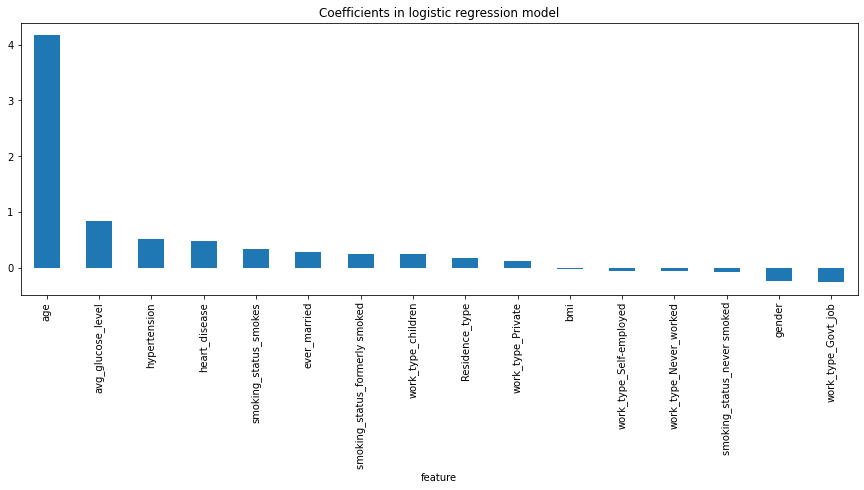

In [62]:
coef_logis = pd.DataFrame({'feature': feature_cols, 'coef': clf_logis.coef_[0]})\
    .sort_values('coef', ascending=False).reset_index(drop=True)
coef_logis.plot(kind='bar', x='feature', y='coef',
                   title='Coefficients in logistic regression model', legend=False, 
                   figsize=(15,5))

#### b) Using PCA data set

In [63]:
clf_logis_pca = train_model(LogisticRegression(tol=0.0001, max_iter=1000), 
                            X_train_pca_smote, y_train_pca_smote, params)

Best parameters: {'C': 0.05}
Best accuracy:  0.7194


In [64]:
test_model(clf_logis_pca, X_test_pca, y_test, 'Logistic Regression', 'PCA')

MCC score:  0.1640


#### c) Using Kernel PCA data set

In [65]:
clf_logis_kpca = train_model(LogisticRegression(tol=0.0001, max_iter=1000), 
                            X_train_kpca_smote, y_train_kpca_smote, params)

Best parameters: {'C': 0.1}
Best accuracy:  0.7203


In [66]:
test_model(clf_logis_kpca, X_test_kpca, y_test, 'Logistic Regression', 'Kernel PCA')

MCC score:  0.1332


### 5.2 Decision Tree

In [67]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

#### a) Using the original features

In [68]:
clf_dectree = train_model(DecisionTreeClassifier(), 
                        X_train_smote, y_train_smote, params)

Best parameters: {'criterion': 'gini', 'max_depth': 8}
Best accuracy:  0.8821


In [69]:
test_model(clf_dectree, X_test, y_test, 'Decision Tree', 'Original', show_report=True)

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       972
           1       0.13      0.72      0.23        50

    accuracy                           0.76      1022
   macro avg       0.56      0.74      0.54      1022
weighted avg       0.94      0.76      0.83      1022

MCC score:  0.2360


#### b) Using PCA data set

In [70]:
clf_dectree_pca = train_model(DecisionTreeClassifier(), 
                            X_train_pca_smote, y_train_pca_smote, params)

Best parameters: {'criterion': 'gini', 'max_depth': 8}
Best accuracy:  0.8574


In [71]:
test_model(clf_dectree_pca, X_test_pca, y_test, 'Decision Tree', 'PCA')

MCC score:  0.1353


#### c) Using Kernel PCA data set

In [72]:
clf_dectree_kpca = train_model(DecisionTreeClassifier(), 
                            X_train_kpca_smote, y_train_kpca_smote, params)

Best parameters: {'criterion': 'gini', 'max_depth': 8}
Best accuracy:  0.8210


In [73]:
test_model(clf_dectree_kpca, X_test_kpca, y_test, 'Decision Tree', 'Kernel PCA')

MCC score:  0.1696


### 5.3 Random Forest

In [74]:
params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
}

#### a) Using the original features

In [75]:
clf_rf = train_model(RandomForestClassifier(), 
                        X_train_smote, y_train_smote, params)

Best parameters: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 200}
Best accuracy:  0.8329


In [76]:
test_model(clf_rf, X_test, y_test, 'Random Forest', 'Original', show_report=True)

              precision    recall  f1-score   support

           0       0.99      0.77      0.86       972
           1       0.15      0.82      0.26        50

    accuracy                           0.77      1022
   macro avg       0.57      0.79      0.56      1022
weighted avg       0.95      0.77      0.83      1022

MCC score:  0.2868


We can get the feature importance in random forest. From the graph below, we have:
- Age and ever married is the first two important features, meanwhile they are correlated. We can conclude that age is the main driver to stroke.
- Hypertension, BMI and glucose level are followed, which is align with what we got from logistic regression model.

<AxesSubplot:title={'center':'Feature Importances in Random Forest Model'}, xlabel='feature'>

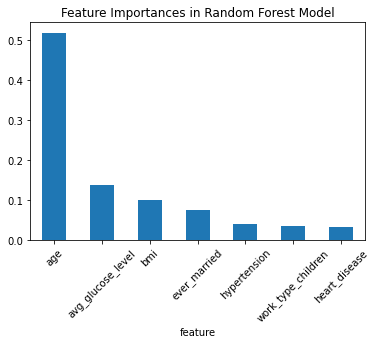

In [77]:
# Get the feature importance from random forest
importances_rf = pd.DataFrame({'feature': feature_cols, 'importance': clf_rf.feature_importances_})\
    .sort_values('importance', ascending=False).reset_index(drop=True)
importances_rf.iloc[0:7, :].plot(kind='bar', x='feature', y='importance', rot=45,
                                       title='Feature Importances in Random Forest Model', legend=False)

#### b) Using PCA data set

In [78]:
clf_rf_pca = train_model(RandomForestClassifier(), 
                            X_train_pca_smote, y_train_pca_smote, params)

Best parameters: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 200}
Best accuracy:  0.8602


In [79]:
test_model(clf_rf_pca, X_test_pca, y_test, 'Random Forest', 'PCA')

MCC score:  0.1859


#### c) Using Kernel PCA data set

In [80]:
clf_rf_kpca = train_model(RandomForestClassifier(), 
                            X_train_kpca_smote, y_train_kpca_smote, params)

Best parameters: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 200}
Best accuracy:  0.8378


In [81]:
test_model(clf_rf_kpca, X_test_kpca, y_test, 'Random Forest', 'Kernel PCA')

MCC score:  0.2159


### 5.4 AdaBoost

In [82]:
params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.1, 0.5, 1.0, 5.0, 10.0],
}

#### a) Using the original features

In [83]:
clf_ada = train_model(AdaBoostClassifier(), 
                        X_train_smote, y_train_smote, params)

Best parameters: {'learning_rate': 1.0, 'n_estimators': 500}
Best accuracy:  0.8650


In [84]:
test_model(clf_ada, X_test, y_test, 'AdaBoost', 'Original', show_report=True)

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       972
           1       0.13      0.58      0.22        50

    accuracy                           0.80      1022
   macro avg       0.55      0.69      0.55      1022
weighted avg       0.93      0.80      0.85      1022

MCC score:  0.2039


#### b) Using PCA data set

In [85]:
clf_ada_pca = train_model(AdaBoostClassifier(), 
                            X_train_pca_smote, y_train_pca_smote, params)

Best parameters: {'learning_rate': 1.0, 'n_estimators': 500}
Best accuracy:  0.9249


In [86]:
test_model(clf_ada_pca, X_test_pca, y_test, 'AdaBoost', 'PCA')

MCC score:  0.1020


#### c) Using Kernel PCA data set

In [87]:
clf_ada_kpca = train_model(AdaBoostClassifier(), 
                            X_train_kpca_smote, y_train_kpca_smote, params)

Best parameters: {'learning_rate': 1.0, 'n_estimators': 500}
Best accuracy:  0.9151


In [88]:
test_model(clf_ada_kpca, X_test_kpca, y_test, 'AdaBoost', 'Kernel PCA')

MCC score:  0.1109


### 5.5 Neural Network
We use Keras to train a shallow neural network for prediction.  
Because the training time for neural network is long, I will only do the training on original feature data set.

First we define the network in a function. Set hidden layer size and learning rate as hyperparameters.  
Here I use SGD for optimization.

In [89]:
def create_model(hidden_size=10, learning_rate=0.01):
    # Model structure
    model = keras.Sequential([
        layers.Input(shape=(16, )),
        layers.Dense(hidden_size, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    # Model training
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.SGD(learning_rate),
        metrics=['accuracy']
    )
    return model

Because the training of neural network takes a lot of time, I just set the hyperparameter list simple.

In [90]:
params = {
    'hidden_size': [5, 10, 20],
    'learning_rate': [0.01],
    'batch_size': [64, 128],
    'epochs': [50, 100]
}

Use the wrapper to make the neural network as a scikit-learn classifier, so that I can use the same function as the other models.

In [91]:
clf_nn = train_model(KerasClassifier(build_fn=create_model, verbose=0), 
                        X_train_smote, y_train_smote, params)

C:\Users\caibo\AppData\Local\Temp/ipykernel_12764/1414649317.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  clf_nn = train_model(KerasClassifier(build_fn=create_model, verbose=0),


Best parameters: {'batch_size': 64, 'epochs': 100, 'hidden_size': 10, 'learning_rate': 0.01}
Best accuracy:  0.7081


In [92]:
test_model(clf_nn, X_test, y_test, 'Neural Network', 'Original', show_report=True)

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.12      0.76      0.21        50

    accuracy                           0.72      1022
   macro avg       0.55      0.74      0.52      1022
weighted avg       0.94      0.72      0.80      1022

MCC score:  0.2253


### 5.6 Summary of Supervised Learning
Let's compare the performance of each models by MCC score and ROC curve.

#### a) Performance of models by MCC score

In [93]:
model_scores = model_scores.sort_values('MCC Score', ascending=False).reset_index(drop=True)

In [94]:
model_scores

,Model Type,Data Set,MCC Score
0,Random Forest,Original,0.286762
1,Logistic Regression,Original,0.269177
2,Decision Tree,Original,0.236046
3,Neural Network,Original,0.225314
4,Random Forest,Kernel PCA,0.215913
5,AdaBoost,Original,0.203908
6,Random Forest,PCA,0.185940
7,Decision Tree,Kernel PCA,0.169648
8,Logistic Regression,PCA,0.163980
9,Decision Tree,PCA,0.135285


#### b) Performance of models on original features by ROC Curve

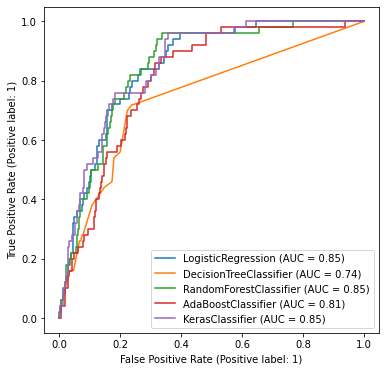

In [95]:
models = [clf_logis, clf_dectree, clf_rf, clf_ada, clf_nn]

# Fix the error that neural network not showing
clf_nn._estimator_type = 'classifier'

f, ax = plt.subplots(figsize=(6, 6))
for model in models:
    plot_roc_curve(model, X_test, y_test, pos_label=1, ax=ax)
    
plt.legend(loc='best')
plt.show()

## 6. Summary and Conclusions

From the above training, we can get a model to predict the stroke with about **70% accuracy** on test set.

Meanwhile, we also find some correlation between features and stroke:
- **Age** is the main driver to stroke. **Older people** are more likely to get a stroke, so we should take care of the health status of old people.
- People with **hypertension** and **higher glucose level** are more likely to get a stroke. That means vascular disease can induce stroke.